### Carlos Alberto Mentado Reyes A01276065
### Fernanda Díaz Gutiérrez A01639572

Para importar el dataset corran en terminal
_pip install uimclrepo_


En el gitignore pongan los archivos de sus virtual environments uwu pofavo

In [16]:
#pip install ucimlrepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk 
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

In [17]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
parkinsons_telemonitoring = fetch_ucirepo(id=189) 
  
# data (as pandas dataframes) 
X = parkinsons_telemonitoring.data.features 
y = parkinsons_telemonitoring.data.targets 
  
# metadata 
print(parkinsons_telemonitoring.metadata) 
  
# variable information 
print(parkinsons_telemonitoring.variables) 


{'uci_id': 189, 'name': 'Parkinsons Telemonitoring', 'repository_url': 'https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring', 'data_url': 'https://archive.ics.uci.edu/static/public/189/data.csv', 'abstract': "Oxford Parkinson's Disease Telemonitoring Dataset", 'area': 'Health and Medicine', 'tasks': ['Regression'], 'characteristics': ['Tabular'], 'num_instances': 5875, 'num_features': 19, 'feature_types': ['Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['motor_UPDRS', 'total_UPDRS'], 'index_col': ['subject#'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5ZS3N', 'creators': ['Athanasios Tsanas', 'Max Little'], 'intro_paper': {'ID': 229, 'type': 'NATIVE', 'title': "Accurate Telemonitoring of Parkinson's Disease Progression by Noninvasive Speech Tests", 'authors': 'A. Tsanas, Max A. Little, P. McSharry, L. Ramig', 'venue': 'IEEE Transactions on Bio

# Modelo lineal
## Entrenar el modelo con las variables asignadas en el ejercicio 

In [18]:
#Usamos un modelo de regresión lineal
#SGDRegressor es un modelo de regresión lineal que se basa en el descenso de gradiente, usado en el notebook anterior
model = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))
target = y["total_UPDRS"]

#Usamos np.array(feature).reshape(-1, 1) porque usando solo una variable necesitamos que tenga la forma correcta
y_pred = cross_val_predict(model, X, target, cv=5)

#Para evaluar el resultado de la predicción con cv checamos el R2 y el MSE
print("R²:", r2_score(target, y_pred))
print("MSE:", mean_squared_error(target, y_pred))

scores = cross_val_score(model, X, target, cv=5)
print("Cross-validated scores:", scores)

R²: -0.20765223676619593
MSE: 138.24788942636445
Cross-validated scores: [-0.08932989 -2.64421342  0.02886456 -0.438519   -1.64699855]


# 4. Modelo No Lineal (KNN)

mejor k por MAE : 1
mejor k por RMSE: 6
mejor k por R2  : 6


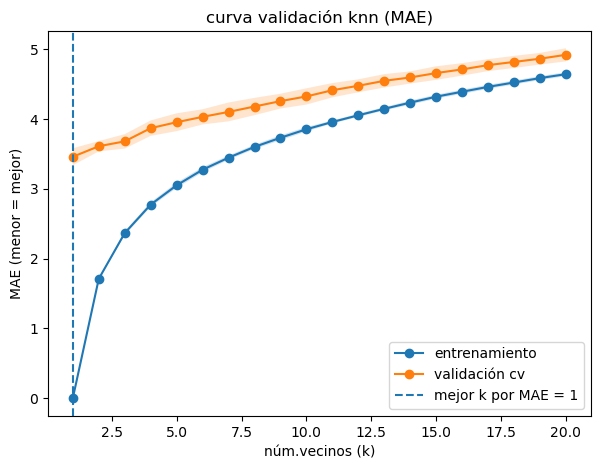

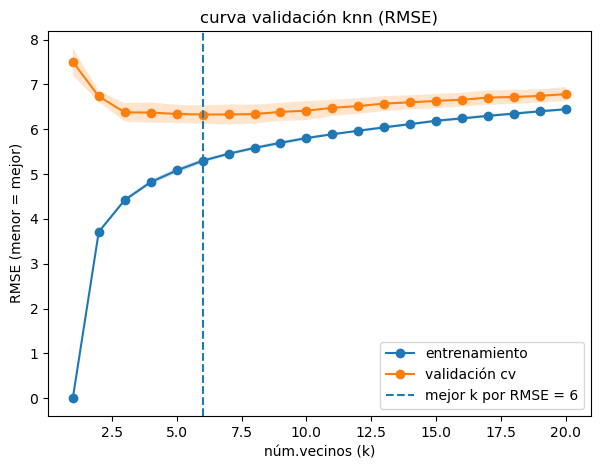

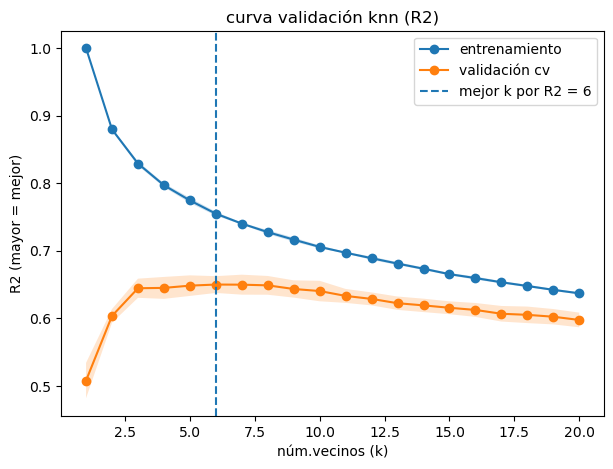

comparación lineal (SGD) vs knn (media ± std, cv=5):


,lineal (SGD),KNN (k=6)
R2,0.1683 ± 0.0224,0.6501 ± 0.0111
RMSE,9.7546 ± 0.2661,6.3268 ± 0.1841
MAE,8.0885 ± 0.2304,4.0294 ± 0.0973
MSE,95.2237 ± 5.1988,40.0617 ± 2.3282


In [48]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

# cv 5 folds 
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# pipeline escalado + KNN
knn_pipe = make_pipeline(StandardScaler(), KNeighborsRegressor())

# reporte (media y std por métrica)
def cv_report(model, X, y, cv):
    out = {}
    scorings = {
        "R2": "r2",
        "RMSE": "neg_root_mean_squared_error",
        "MAE": "neg_mean_absolute_error",
        "MSE": "neg_mean_squared_error"  
    }
    for name, scoring in scorings.items():
        scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
        if name in ("RMSE", "MAE", "MSE"):
            scores = -scores  # pasar a positivo
        out[name] = (scores.mean(), scores.std())
    return out

# cv knn
from sklearn.model_selection import validation_curve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

metricas = {
    "R2": "r2",
    "MAE": "neg_mean_absolute_error",
    "RMSE": "neg_root_mean_squared_error"
}
k_vals = np.arange(1, 21)

curvas_val = {}
for metrica, scoring in metricas.items():
    train_scores, valid_scores = validation_curve(
        knn_pipe, X, y,
        param_name="kneighborsregressor__n_neighbors",
        param_range=k_vals,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )
    if metrica in ("MAE","RMSE"):
        train_scores, valid_scores = -train_scores, -valid_scores  # signo positivo en MAE/RMSE
    curvas_val[metrica] = {
        "train_mean": train_scores.mean(axis=1), "train_std": train_scores.std(axis=1, ddof=1),
        "valid_mean": valid_scores.mean(axis=1), "valid_std": valid_scores.std(axis=1, ddof=1)
    }

# k óptimo por MAE (min), por R2 (máx) y RMSE (min)
bestk_mae  = int(k_vals[np.argmin(curvas_val["MAE"]["valid_mean"])])
bestk_rmse = int(k_vals[np.argmin(curvas_val["RMSE"]["valid_mean"])])
bestk_r2   = int(k_vals[np.argmax(curvas_val["R2"]["valid_mean"])])

print(f"mejor k por MAE : {bestk_mae}")
print(f"mejor k por RMSE: {bestk_rmse}")
print(f"mejor k por R2  : {bestk_r2}")

# resumen (curva validación media ± std) para c/k
sum_val = pd.DataFrame({
    "k": k_vals,
    "R2_mean":  curvas_val["R2"]["valid_mean"],
    "R2_std":   curvas_val["R2"]["valid_std"],
    "MAE_mean": curvas_val["MAE"]["valid_mean"],
    "MAE_std":  curvas_val["MAE"]["valid_std"],
    "RMSE_mean":curvas_val["RMSE"]["valid_mean"],
    "RMSE_std": curvas_val["RMSE"]["valid_std"],
}).round(4)
sum_val

# gráficas (1 por métrica)
for metrica in ["MAE","RMSE","R2"]:
    m = curvas_val[metrica]
    plt.figure(figsize=(7,5))
    plt.plot(k_vals, m["train_mean"], marker="o", label="entrenamiento")
    plt.fill_between(k_vals, m["train_mean"]-m["train_std"], m["train_mean"]+m["train_std"], alpha=0.2)
    plt.plot(k_vals, m["valid_mean"], marker="o", label="validación cv")
    plt.fill_between(k_vals, m["valid_mean"]-m["valid_std"], m["valid_mean"]+m["valid_std"], alpha=0.2)
    if metrica in ("MAE","RMSE"):
        best_k_tmp = int(k_vals[np.argmin(m["valid_mean"])])
        plt.axvline(best_k_tmp, ls="--", label=f"mejor k por {metrica} = {best_k_tmp}")
        ylabel = metrica + " (menor = mejor)"
    else:
        best_k_tmp = int(k_vals[np.argmax(m["valid_mean"])])
        plt.axvline(best_k_tmp, ls="--", label=f"mejor k por {metrica} = {best_k_tmp}")
        ylabel = metrica + " (mayor = mejor)"
    plt.xlabel("núm.vecinos (k)")
    plt.ylabel(ylabel)
    plt.title(f"curva validación knn ({metrica})")
    plt.legend()
    plt.show()

# k óptimo el de RMSE
best_k = bestk_rmse

# comparación final contra el modelo lineal SGDRegressor 
from sklearn.linear_model import SGDRegressor  
knn_final = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=best_k))
res_knn = cv_report(knn_final, X, y, cv)
sgd_lineal = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3, random_state=42))
res_sgd = cv_report(sgd_lineal, X, y, cv)
res_cmp = pd.DataFrame(
    {
        "lineal (SGD)": [f"{res_sgd['R2'][0]:.4f} ± {res_sgd['R2'][1]:.4f}",
                         f"{res_sgd['RMSE'][0]:.4f} ± {res_sgd['RMSE'][1]:.4f}",
                         f"{res_sgd['MAE'][0]:.4f} ± {res_sgd['MAE'][1]:.4f}",
                         f"{res_sgd['MSE'][0]:.4f} ± {res_sgd['MSE'][1]:.4f}"],
        f"KNN (k={best_k})": [f"{res_knn['R2'][0]:.4f} ± {res_knn['R2'][1]:.4f}",
                             f"{res_knn['RMSE'][0]:.4f} ± {res_knn['RMSE'][1]:.4f}",
                             f"{res_knn['MAE'][0]:.4f} ± {res_knn['MAE'][1]:.4f}",
                             f"{res_knn['MSE'][0]:.4f} ± {res_knn['MSE'][1]:.4f}"]
    },
    index=["R2", "RMSE", "MAE", "MSE"]
)
print("comparación lineal (SGD) vs knn (media ± std, cv=5):")
display(res_cmp)

### 4. Observaciones / conclusiones KNN vs lineal:

Cuando se entrena el modelo KNN con crossvalidation de 5 folds y se exploran los valores de k del 1-20, se obtuvo que el menor MAE sucede en k=1 pero hay mucho overfitting. Cuando se analiza RMSE y R2, el mejor balance sesgo/var se obtiene en k=6, en donde el modelo alcanza aprox. R2= 0.6, RMSE=6.3 y MAE=4.03. A comparación del lineal, que logró solamente R2=0.17, RMSE=9.7 y MAE=8.07, podemos entonces decir que el KNN supera al modelo lineal en las métricas porque captura mejor las relaciones (nolineales) en los datos para predecir la severidad de la enfermedad (total_UPDRS).

Nota: los números del lineal aquí reportados son del mismo modelo (SGDRegressor) re-evaluado con el mismo protocolo de cv y métricas que KNN, por ello pueden diferir un poco de la pt.1
